# Цель лабораторной работы
Изучение сложных способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.
# Задание 
1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
3. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
4. Произведите подбор гиперпараметра K с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Желательно использование нескольких стратегий кросс-валидации.
5. Сравните метрики качества исходной и оптимальной моделей.

# Ход выполнения работы


## 1) Набор данных для решения задачи классификации или регрессии

В качестве набора данных используется набор данных по раку груди висконсин (диагностический)
Файл содержит следующие колонки:

- радиус (среднее расстояние от центра до точек по периметру)
- текстура (стандартное отклонение значений шкалы серого)
- периметр
- область
- гладкость (локальное изменение длины радиуса)
- компактность (периметр ^ 2 / площадь - 1.0)
- вогнутость (выраженность вогнутых участков контура)
- вогнутые точки (количество вогнутых участков контура)
- симметрия
- фрактальная размерность («приближение береговой линии» - 1)

Классы:
- WDBC-злокачественный
- WDBC-доброкачественный

In [91]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Tuple
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
%matplotlib inline 
sns.set(style="ticks")
from sklearn.datasets import *



from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")


In [2]:
breast = load_breast_cancer()

In [3]:
breast['feature_names']

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [4]:
breast['target_names']

array(['malignant', 'benign'], dtype='<U9')

In [5]:
breast['data'].shape

(569, 30)

In [6]:
breast['target'].shape

(569,)

In [7]:
data = pd.DataFrame(data= np.c_[breast['data'], breast['target']],
                     columns= list(breast['feature_names']) + ['target'])

In [8]:
data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0.0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0.0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0.0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0.0


In [9]:
# Значения целевого признака
np.unique(breast.target)

array([0, 1])

In [10]:
# Наименования значений целевого признака
breast.target_names

array(['malignant', 'benign'], dtype='<U9')

In [11]:
list(zip(np.unique(breast.target), breast.target_names))

[(0, 'malignant'), (1, 'benign')]

In [12]:
# Значения целевого признака
breast.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [13]:
# Размер выборки
breast.data.shape, breast.target.shape

((569, 30), (569,))

In [14]:
# И выведем его статистические характеристики
data.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


## Разделение выборки на обучающую и тестовую

In [15]:
breast_X_train, breast_X_test, breast_y_train, breast_y_test = train_test_split(
    breast.data, breast.target, test_size=0.5, random_state=1)

In [16]:
# Размер обучающей выборки
breast_X_train.shape, breast_y_train.shape

((284, 30), (284,))

In [17]:
# Размер тестовой выборки
breast_X_test.shape, breast_y_test.shape

((285, 30), (285,))

In [18]:
np.unique(breast_y_train)

array([0, 1])

In [19]:
np.unique(breast_y_test)

array([0, 1])

In [20]:
def class_proportions(array: np.ndarray) -> Dict[int, Tuple[int, float]]:
    """
    Вычисляет пропорции классов
    array - массив, содержащий метки классов
    """
    # Получение меток классов и количества меток каждого класса 
    labels, counts = np.unique(array, return_counts=True)
    # Превращаем количество меток в процент их встречаемости
    # делим количество меток каждого класса на общее количество меток
    counts_perc = counts/array.size
    # Теперь sum(counts_perc)==1.0
    # Создаем результирующий словарь,
    # ключом словаря явлется метка класса, 
    # а значением словаря процент встречаемости метки
    res = dict()
    for label, count2 in zip(labels, zip(counts, counts_perc)):
        res[label] = count2
    return res

def print_class_proportions(array: np.ndarray):
    """
    Вывод пропорций классов
    """
    proportions = class_proportions(array)
    if len(proportions)>0:
        print('Метка \t Количество \t Процент встречаемости')
    for i in proportions:
        val, val_perc = proportions[i]
        val_perc_100 = round(val_perc * 100, 2)
        print('{} \t {} \t \t {}%'.format(i, val, val_perc_100))

In [21]:
print_class_proportions(breast.target)

Метка 	 Количество 	 Процент встречаемости
0 	 212 	 	 37.26%
1 	 357 	 	 62.74%


In [22]:
# Для обучающей выборки
print_class_proportions(breast_y_train)

Метка 	 Количество 	 Процент встречаемости
0 	 109 	 	 38.38%
1 	 175 	 	 61.62%


In [23]:
# Для тестовой выборки
print_class_proportions(breast_y_test)

Метка 	 Количество 	 Процент встречаемости
0 	 103 	 	 36.14%
1 	 182 	 	 63.86%


In [24]:
# 2 ближайших соседа
cl1_1 = KNeighborsClassifier(n_neighbors=2)
cl1_1.fit(breast_X_train, breast_y_train)
target1_1 = cl1_1.predict(breast_X_test)
len(target1_1), target1_1

(285,
 array([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]))

In [25]:
# 10 ближайших соседей
cl1_2 = KNeighborsClassifier(n_neighbors=10)
cl1_2.fit(breast_X_train, breast_y_train)
target1_2 = cl1_2.predict(breast_X_test)
len(target1_2), target1_2

(285,
 array([1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]))

In [26]:
# 2 ближайших соседа
accuracy_score(breast_y_test, target1_1)

0.8842105263157894

In [27]:
# 10 ближайших соседей
accuracy_score(breast_y_test, target1_2)

0.9157894736842105

Точность в случае 10 ближайших соседей составляет более 88%, а точность в случае 2 ближайших соседей составляет 91%.

In [28]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [29]:
# 2 ближайших соседа
print_accuracy_score_for_classes(breast_y_test, target1_1)

Метка 	 Accuracy
0 	 0.883495145631068
1 	 0.8846153846153846


In [30]:
# 10 ближайших соседей
print_accuracy_score_for_classes(breast_y_test, target1_2)

Метка 	 Accuracy
0 	 0.8446601941747572
1 	 0.9560439560439561


In [31]:
balanced_accuracy_score(breast_y_test, target1_1)

0.8840552651232263

In [32]:
balanced_accuracy_score(breast_y_test, target1_2)

0.9003520751093567

## Mатрица ошибок или Confusion Matrix

In [33]:
confusion_matrix(breast_y_test, target1_1, labels=[0, 1])

array([[ 91,  12],
       [ 21, 161]], dtype=int64)

In [34]:
tn, fp, fn, tp = confusion_matrix(breast_y_test, target1_1).ravel()
tn, fp, fn, tp

(91, 12, 21, 161)

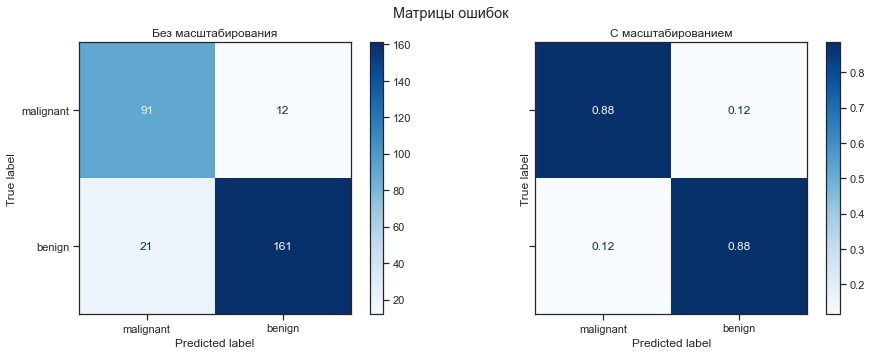

In [35]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,5))

plot_confusion_matrix(cl1_1, breast_X_test, breast_y_test, 
                      display_labels=breast.target_names, cmap=plt.cm.Blues, ax=ax[0])

plot_confusion_matrix(cl1_1, breast_X_test, breast_y_test, 
                      display_labels=breast.target_names, 
                      cmap=plt.cm.Blues, normalize='true', ax=ax[1])

fig.suptitle('Матрицы ошибок')
ax[0].title.set_text('Без масштабирования')
ax[1].title.set_text('С масштабированием')

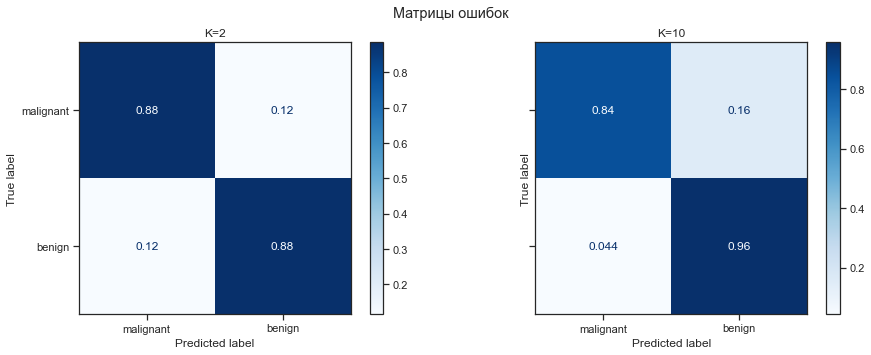

In [36]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,5))

plot_confusion_matrix(cl1_1, breast_X_test, breast_y_test, 
                      display_labels=breast.target_names, 
                      cmap=plt.cm.Blues, normalize='true', ax=ax[0])

plot_confusion_matrix(cl1_2, breast_X_test, breast_y_test, 
                      display_labels=breast.target_names, 
                      cmap=plt.cm.Blues, normalize='true', ax=ax[1])

fig.suptitle('Матрицы ошибок')
ax[0].title.set_text('K=2')
ax[1].title.set_text('K=10')

In [37]:
# precision=TP/(TP+FP)
# recall=TP/(TP+FN)
# Для 2 ближайших соседей
precision_score(breast_y_test, target1_1), recall_score(breast_y_test, target1_1)

(0.930635838150289, 0.8846153846153846)

In [38]:
# Для 2 ближайших соседей
precision_score(breast_y_test, target1_2), recall_score(breast_y_test, target1_2)

(0.9157894736842105, 0.9560439560439561)

In [39]:
# Параметры TP, TN, FP, FN считаются как сумма по всем классам
precision_score(breast_y_test, target1_1, average='micro')

0.8842105263157894

In [40]:
# Параметры TP, TN, FP, FN считаются отдельно для каждого класса 
# и берется среднее значение, дисбаланс классов не учитывается.
precision_score(breast_y_test, target1_1, average='macro')

0.8715679190751445

In [41]:
# Параметры TP, TN, FP, FN считаются отдельно для каждого класса 
# и берется средневзвешенное значение, дисбаланс классов учитывается 
# в виде веса классов (вес - количество истинных значений каждого класса).
precision_score(breast_y_test, target1_1, average='weighted')

0.8879411317310617

## ROC-кривая 

In [42]:
# Обучим модели на задаче бинарной классифкации, 
# чтобы получить вероятности классов

# 2 ближайших соседа
bin_cl1_1 = KNeighborsClassifier(n_neighbors=2)
bin_cl1_1.fit(breast_X_train, breast_y_train)
# предскажем метки классов
bin_cl1_1.predict(breast_X_test)

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [43]:
# предскажем вероятности классов
proba_target1_1 = bin_cl1_1.predict_proba(breast_X_test)
len(proba_target1_1), proba_target1_1

(285,
 array([[1. , 0. ],
        [1. , 0. ],
        [0. , 1. ],
        [1. , 0. ],
        [0.5, 0.5],
        [1. , 0. ],
        [1. , 0. ],
        [0.5, 0.5],
        [0. , 1. ],
        [0. , 1. ],
        [0. , 1. ],
        [1. , 0. ],
        [0.5, 0.5],
        [0. , 1. ],
        [1. , 0. ],
        [0.5, 0.5],
        [0. , 1. ],
        [0. , 1. ],
        [0. , 1. ],
        [1. , 0. ],
        [0. , 1. ],
        [0. , 1. ],
        [1. , 0. ],
        [0. , 1. ],
        [1. , 0. ],
        [0. , 1. ],
        [0. , 1. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [0. , 1. ],
        [1. , 0. ],
        [0.5, 0.5],
        [0. , 1. ],
        [0. , 1. ],
        [1. , 0. ],
        [1. , 0. ],
        [0. , 1. ],
        [0. , 1. ],
        [0. , 1. ],
        [0. , 1. ],
        [0. , 1. ],
        [0. , 1. ],
        [0. , 1. ],
        [0.5, 0.5],
        [0. , 1. ],
        [0. , 1. ],
        [0.5, 0.5],
        [0.5, 

In [44]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label, average):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

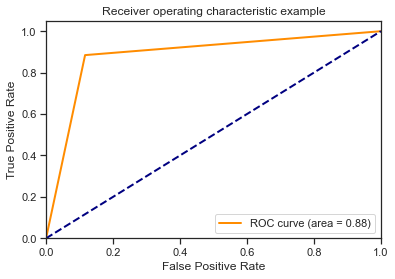

In [45]:
# Для 2 ближайших соседей
draw_roc_curve(breast_y_test, target1_1, pos_label=1, average='micro')

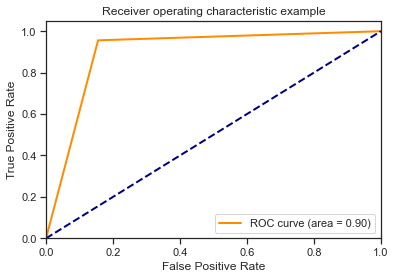

In [46]:
# Для 10 ближайших соседей
draw_roc_curve(breast_y_test, target1_2, pos_label=1, average='micro')

## Кросс-валидация

Стратегия кросс-валидации определяется автоматически.

In [47]:
#кросс-валидации определяется автоматически.
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         breast.data, breast.target, cv=3)

In [48]:
# Значение метрики accuracy для 3 фолдов
scores

array([0.89473684, 0.93157895, 0.88888889])

In [49]:
# Усредненное значение метрики accuracy для 3 фолдов
np.mean(scores)

0.9050682261208577

In [50]:
# Укажем несколько метрик
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

In [51]:
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        breast.data, breast.target, scoring=scoring, 
                        cv=3, return_train_score=True)
scores

{'fit_time': array([0.00199986, 0.0019989 , 0.00199914]),
 'score_time': array([0.00899601, 0.00799751, 0.0069983 ]),
 'test_precision': array([0.89432078, 0.93182303, 0.89533308]),
 'train_precision': array([0.9776781 , 0.97082105, 0.96429769]),
 'test_recall': array([0.89473684, 0.93157895, 0.88888889]),
 'train_recall': array([0.9762533 , 0.96833773, 0.96052632]),
 'test_f1': array([0.89442356, 0.93167383, 0.89006119]),
 'train_f1': array([0.97639169, 0.96857447, 0.96087426])}

### K-fold стратегия

In [52]:
# Возвращаются индексы элементов
X = ["a", "b", "c"]
kf = KFold(n_splits=3)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[1 2] [0]
[0 2] [1]
[0 1] [2]


In [53]:
X = range(12)
kf = KFold(n_splits=3)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 4  5  6  7  8  9 10 11] [0 1 2 3]
[ 0  1  2  3  8  9 10 11] [4 5 6 7]
[0 1 2 3 4 5 6 7] [ 8  9 10 11]


In [86]:
%%time
kf = KFold(n_splits=5)
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         breast.data, breast.target, scoring='f1_weighted', 
                         cv=kf)
scores

Wall time: 35 ms


array([0.87833964, 0.9122807 , 0.94764978, 0.90663256, 0.89111744])

In [55]:
np.mean(scores)

0.9072040226904188

In [85]:
%%time
kf = KFold(n_splits=5)
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        breast.data, breast.target, scoring=scoring, 
                        cv=kf, return_train_score=True)
scores

Wall time: 114 ms


{'fit_time': array([0.00198936, 0.00199842, 0.00099921, 0.00199938, 0.00200915]),
 'score_time': array([0.00600719, 0.00499892, 0.00599837, 0.00499892, 0.00498867]),
 'test_precision': array([0.89296517, 0.9122807 , 0.94855194, 0.9172852 , 0.91524629]),
 'train_precision': array([0.97753988, 0.96981109, 0.96967738, 0.96766249, 0.97335361]),
 'test_recall': array([0.87719298, 0.9122807 , 0.94736842, 0.90350877, 0.88495575]),
 'train_recall': array([0.97582418, 0.96703297, 0.96703297, 0.96483516, 0.97149123]),
 'test_f1': array([0.87833964, 0.9122807 , 0.94764978, 0.90663256, 0.89111744]),
 'train_f1': array([0.97605126, 0.96732351, 0.96727296, 0.9650388 , 0.97162092])}

### Repeated K-fold стратегия

In [58]:
X = range(12)
kf = RepeatedKFold(n_splits=3, n_repeats=2)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 0  1  2  3  5  8 10 11] [4 6 7 9]
[ 1  3  4  5  6  7  9 11] [ 0  2  8 10]
[ 0  2  4  6  7  8  9 10] [ 1  3  5 11]
[ 0  3  4  6  7  8  9 11] [ 1  2  5 10]
[ 1  2  3  5  7  9 10 11] [0 4 6 8]
[ 0  1  2  4  5  6  8 10] [ 3  7  9 11]


In [83]:
%%time
kf = RepeatedKFold(n_splits=5)
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         breast.data, breast.target, scoring='f1_weighted', 
                         cv=kf)
scores

Wall time: 293 ms


array([0.9122807 , 0.93893634, 0.93881285, 0.92115825, 0.87851886,
       0.86921876, 0.92982456, 0.89512998, 0.90452447, 0.93826095,
       0.90499543, 0.92098518, 0.89538462, 0.92269583, 0.93832189,
       0.92072881, 0.93004741, 0.92129267, 0.89570224, 0.90370133,
       0.87719298, 0.8862572 , 0.92128737, 0.94831354, 0.89438971,
       0.93880518, 0.90394407, 0.91339143, 0.91184559, 0.91204647,
       0.87939827, 0.87836294, 0.93849379, 0.9472189 , 0.90333714,
       0.90448375, 0.90363786, 0.90331378, 0.89668016, 0.96477389,
       0.87719298, 0.90431104, 0.89547718, 0.93063063, 0.92937286,
       0.89503589, 0.8872846 , 0.90339719, 0.92982456, 0.93040369])

In [61]:
np.mean(scores)

0.9127621007716087

## Leave One Out (LOO)

In [62]:
X = range(12)
# Эквивалент KFold(n_splits=n)
kf = LeaveOneOut()
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 1  2  3  4  5  6  7  8  9 10 11] [0]
[ 0  2  3  4  5  6  7  8  9 10 11] [1]
[ 0  1  3  4  5  6  7  8  9 10 11] [2]
[ 0  1  2  4  5  6  7  8  9 10 11] [3]
[ 0  1  2  3  5  6  7  8  9 10 11] [4]
[ 0  1  2  3  4  6  7  8  9 10 11] [5]
[ 0  1  2  3  4  5  7  8  9 10 11] [6]
[ 0  1  2  3  4  5  6  8  9 10 11] [7]
[ 0  1  2  3  4  5  6  7  9 10 11] [8]
[ 0  1  2  3  4  5  6  7  8 10 11] [9]
[ 0  1  2  3  4  5  6  7  8  9 11] [10]
[ 0  1  2  3  4  5  6  7  8  9 10] [11]


In [82]:
%%time
kf = LeaveOneOut()
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         breast.data, breast.target, scoring='f1_weighted', 
                         cv=kf)
scores

Wall time: 2.12 s


array([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [77]:
np.mean(scores)

0.9086115992970123

## Leave P Out (LPO)

In [79]:
X = range(12)
# Эквивалент KFold(n_splits=n)
kf = LeavePOut(2)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

[ 2  3  4  5  6  7  8  9 10 11] [0 1]
[ 1  3  4  5  6  7  8  9 10 11] [0 2]
[ 1  2  4  5  6  7  8  9 10 11] [0 3]
[ 1  2  3  5  6  7  8  9 10 11] [0 4]
[ 1  2  3  4  6  7  8  9 10 11] [0 5]
[ 1  2  3  4  5  7  8  9 10 11] [0 6]
[ 1  2  3  4  5  6  8  9 10 11] [0 7]
[ 1  2  3  4  5  6  7  9 10 11] [0 8]
[ 1  2  3  4  5  6  7  8 10 11] [0 9]
[ 1  2  3  4  5  6  7  8  9 11] [ 0 10]
[ 1  2  3  4  5  6  7  8  9 10] [ 0 11]
[ 0  3  4  5  6  7  8  9 10 11] [1 2]
[ 0  2  4  5  6  7  8  9 10 11] [1 3]
[ 0  2  3  5  6  7  8  9 10 11] [1 4]
[ 0  2  3  4  6  7  8  9 10 11] [1 5]
[ 0  2  3  4  5  7  8  9 10 11] [1 6]
[ 0  2  3  4  5  6  8  9 10 11] [1 7]
[ 0  2  3  4  5  6  7  9 10 11] [1 8]
[ 0  2  3  4  5  6  7  8 10 11] [1 9]
[ 0  2  3  4  5  6  7  8  9 11] [ 1 10]
[ 0  2  3  4  5  6  7  8  9 10] [ 1 11]
[ 0  1  4  5  6  7  8  9 10 11] [2 3]
[ 0  1  3  5  6  7  8  9 10 11] [2 4]
[ 0  1  3  4  6  7  8  9 10 11] [2 5]
[ 0  1  3  4  5  7  8  9 10 11] [2 6]
[ 0  1  3  4  5  6  8  9 10 11] [2 7]
[ 0 

In [1]:
#%%time
#kf = LeavePOut(2)
#scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         #breast.data, breast.target, scoring='f1_weighted', 
                         #cv=kf)
#scores

## Подбор гиперпараметров GridSearchCV

In [64]:
breast_X_train.shape

(284, 30)

In [88]:
n_range = np.array(range(1,200,1))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
          27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
          40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
          53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
          66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
          79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
          92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
         105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
         118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
         131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
         144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
         157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
         170, 171, 172,

In [89]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=6, scoring='accuracy')
clf_gs.fit(breast_X_train, breast_y_train)

Wall time: 3.67 s


GridSearchCV(cv=6, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        9...
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 18

### Лучшая модель

In [96]:
clf_gs.best_estimator_

KNeighborsClassifier(n_neighbors=10)

In [97]:
clf_gs.best_params_

{'n_neighbors': 10}

### Изменение качества на тестовой выборке в зависимости от К-соседей

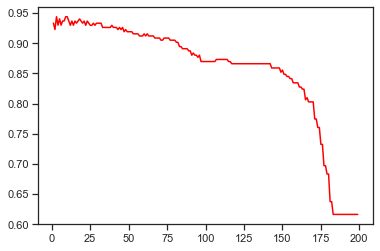

In [98]:
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'], color="red")

## Подбор гиперпараметров  RandomizedSearchCV 

In [130]:
%%time
clf_rs = RandomizedSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_rs.fit(breast_X_train, breast_y_train)

Wall time: 188 ms


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions=[{'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  8...
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189

In [131]:
clf_rs.best_score_, clf_rs.best_params_

(0.9364661654135338, {'n_neighbors': 16})

In [116]:
clf_gs.best_score_, clf_gs.best_params_

(0.9437795508274233, {'n_neighbors': 10})

## Качество оптимальной модели.

In [103]:
# 10 ближайших соседа
cl1_3 = KNeighborsClassifier(n_neighbors=10)
cl1_3.fit(breast_X_train, breast_y_train)
target1_3 = cl1_3.predict(breast_X_test)

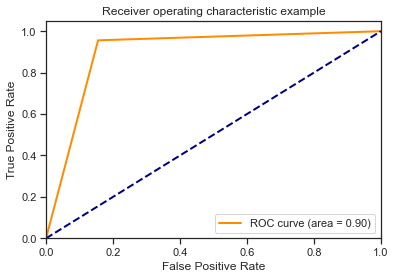

In [104]:
# Для 10 ближайших соседей
draw_roc_curve(breast_y_test, target1_3, pos_label=1, average='micro')

In [105]:
# Для 10 ближайших соседей
print_accuracy_score_for_classes(breast_y_test, target1_3)

Метка 	 Accuracy
0 	 0.8446601941747572
1 	 0.9560439560439561


In [134]:
# 16 ближайших соседа
cl1_4 = KNeighborsClassifier(n_neighbors=16)
cl1_4.fit(breast_X_train, breast_y_train)
target1_4 = cl1_4.predict(breast_X_test)

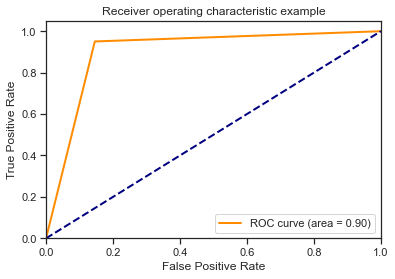

In [108]:
# Для 16 ближайших соседей
draw_roc_curve(breast_y_test, target1_4, pos_label=1, average='micro')

In [110]:
# Для 16 ближайших соседей
print_accuracy_score_for_classes(breast_y_test, target1_4)

Метка 	 Accuracy
0 	 0.8543689320388349
1 	 0.9505494505494505


## Сравнение метрики качества исходной и оптимальной модели 

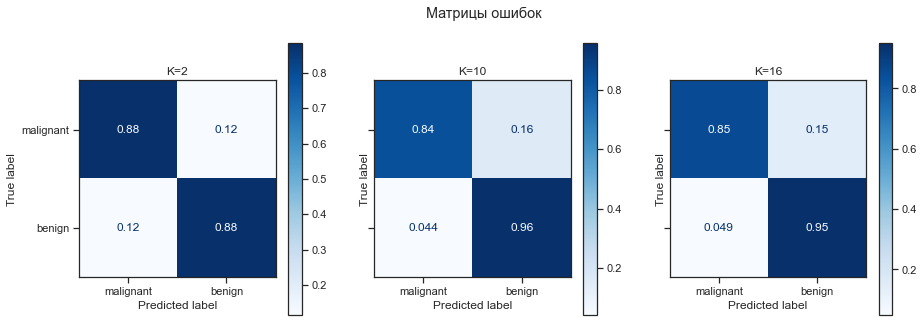

In [111]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,5))

plot_confusion_matrix(cl1_1, breast_X_test, breast_y_test, 
                      display_labels=breast.target_names, 
                      cmap=plt.cm.Blues, normalize='true', ax=ax[0])

plot_confusion_matrix(cl1_3, breast_X_test, breast_y_test, 
                      display_labels=breast.target_names, 
                      cmap=plt.cm.Blues, normalize='true', ax=ax[1])

plot_confusion_matrix(cl1_4, breast_X_test, breast_y_test, 
                      display_labels=breast.target_names, 
                      cmap=plt.cm.Blues, normalize='true', ax=ax[2])

fig.suptitle('Матрицы ошибок')
ax[0].title.set_text('K=2')
ax[1].title.set_text('K=10')
ax[2].title.set_text('K=16')